# Validate temporally
In this script, validation is performed temporally.  
To do this, the final 20% of data is used for testing, and the first 80% is used for training.  

Potential issues: the final portion of time might exhibit different patterns to the rest of the time.  
There are some sensors that only start operating towards the end, so the model would have no chance to learn about their behaviour.  

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.colors as colors
from sklearn.model_selection import TimeSeriesSplit
import time as time
#  Spatial packages
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx
import selenium
# Machine learning packages
# import xgboost as xgb

# Custom function for neg_mean_absolute_percentage_error
def neg_mean_absolute_percentage_error(y_true, y_pred):
    return -100 * np.mean(np.abs((y_true - y_pred) / y_true))

from Functions import *

### Get the necessary data
#### Get testing and training data
Specify buffer size (as there are different versions of the data created with different buffer sizes)

In [2]:
buffer_size_m = 400
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

In [20]:
datetimes = pd.read_csv(input_csv)['datetime']
sensor_ids = pd.read_csv(input_csv)['sensor_id']

### Cut off data post-Covid

In [21]:
Xfull= Xfull[0:2198889]
Yfull= Yfull[0:2198889]
data_time_columns = data_time_columns[0:2198889]
sensor_ids = sensor_ids[0:2198889]

#### Drop one version of the time variables (either cyclical or dummy versions)

In [5]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

#### Delete the year variable

In [6]:
del Xfull['year']

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [7]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']

### Set up model pipelines

In [8]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])

In [9]:
models_dict = {"rf_regressor":rf_model_pipeline}

## Validation manually 

In [10]:
train_index = Xfull[0:int(len(Xfull)*0.8)].index.tolist()
test_index = Xfull[int(len(Xfull)*0.8):].index.tolist()

In [11]:
# Lists to store the scores
mae_scores = []
rmse_scores= []
r2_scores= []
neg_mae_scores = []
# Lists to store predicetd and actual values
predicted_values=[]
observed_values = []
# List to store the datetimes
datetimes_used = []

In [12]:
start = time()

# Get train and testing data for this fold
print(f"train index: {len(train_index)}")
print(f"test index: {len(test_index)}")
print(f"percentage of data used as testing: {round(len(test_index)/len(train_index)*100,1)}")

X_train, X_test = Xfull.iloc[train_index], Xfull.iloc[test_index]
y_train, y_test = Yfull[train_index], Yfull[test_index]
date_time_cols_train, date_time_cols_test =  data_time_columns.iloc[train_index], data_time_columns.iloc[test_index]
sensor_ids_train, sensor_ids_test =  sensor_ids.iloc[train_index], sensor_ids.iloc[test_index]

# Fit the model on the training data
rf_model_pipeline.fit(X_train, y_train)
# Use it to make predictions on the testing data, and store these
y_pred = rf_model_pipeline.predict(X_test)
predicted_values.append(y_pred)
# Store the datetimes
datetimes_used.append(datetimes[train_index])
# Store the actual values for the testing data
observed_values.append(y_test)
# Calculate the error metrics for this fold and append to the scores lists
mae_scores.append(mean_absolute_error(y_test, y_pred))
r2_scores.append(r2_score(y_test, y_pred))
rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
neg_mae_scores = [-score for score in mae_scores]        

end = time()
print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))

train index: 1759111
test index: 439778
percentage of data used as testing: 25.0
Ran cross_val_predict in 8 minutes


In [13]:
predicted_values_all = []
observed_values_all= []
for i in range(len(predicted_values)):
    for j in range(len(predicted_values[i])):
        observed_values_all.append(observed_values[i][j])
        predicted_values_all.append(predicted_values[i][j])

## Print scores

In [14]:
print(f"Mean absoloute error: {mae_scores}")
print(f"Mean R2: {r2_scores}")
print(f"Mean RMSE: {rmse_scores}")

Mean absoloute error: [96.02109998681155]
Mean R2: [0.878303753576306]
Mean RMSE: [185.2527748991376]


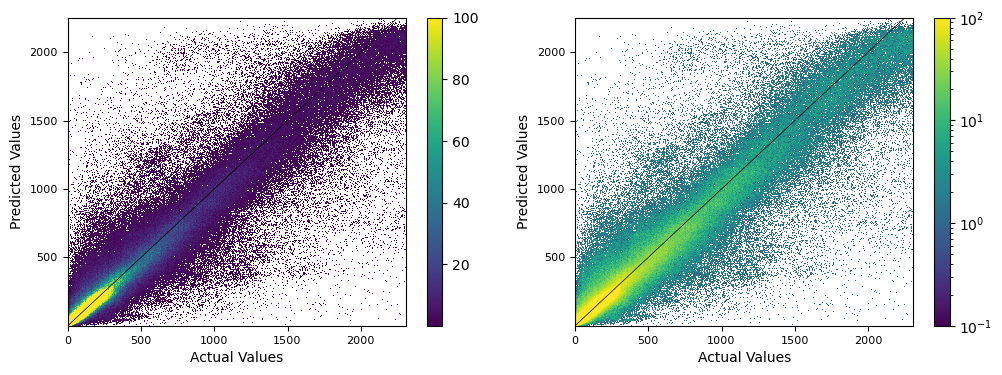

In [15]:
import datashader as ds
from datashader.mpl_ext import dsshow
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], y_test, predicted_values_all, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

# Plot with log scale
using_datashader(axs[1], y_test, predicted_values_all, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
axs[1].tick_params(axis='both', which='major', labelsize=8)

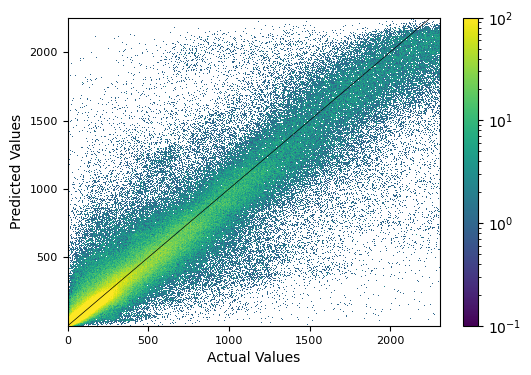

In [16]:
import datashader as ds
from datashader.mpl_ext import dsshow
fig, ax= plt.subplots(figsize = (6,4))

# Plot with log scale
using_datashader(ax, y_test, predicted_values_all, 'log')
ax.plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
ax.set_ylabel("Predicted Values", size=10)
ax.set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
ax.tick_params(axis='both', which='major', labelsize=8)

In [17]:
# cv_parameters =x KFolxd(n_splits=2, random_state=1, shuffle=True)

## Find the error in the predictions broken down by hour and sensor

In [27]:
# Get all relevant data in one dataframe
df =pd.DataFrame({'Predictions': predicted_values_all, 'Real_vals':y_test, 'Hour': date_time_cols_test['time'],
                  'Weekday': date_time_cols_test['weekday_num']
                  ,'sensor_id':sensor_ids_test
                  ,'AbsolouteError':abs(y_test-predicted_values_all)
                , 'Error':y_test-predicted_values_all, 'datetime':date_time_cols_test['datetime']})

# Add hour of week variable
df['hour_of_week'] = df.apply (lambda row: label_hour_of_week(row), axis=1)
# Sort by this variable
df=df.sort_values(by=['Weekday', 'Hour'])
df.head()

df['Percentage_Difference']= abs(df['Real_vals'] - df['Predictions'])/((df['Real_vals'] + df['Predictions'])/2)* 100
df['Percentage_Increase']= ((df['Real_vals'] - df['Predictions']) / abs(df['Predictions'])) * 100

df

,Predictions,Real_vals,Hour,Weekday,sensor_id,AbsolouteError,Error,datetime,hour_of_week,Percentage_Difference,Percentage_Increase
1762926,22.28,18,0,1,27,4.28,-4.28,2018-02-19 00:00:00,w1_h0,21.251241,-19.210054
1762927,127.06,132,0,1,45,4.94,4.94,2018-02-19 00:00:00,w1_h0,3.813788,3.887927
1762928,166.79,85,0,1,15,81.79,-81.79,2018-02-19 00:00:00,w1_h0,64.966837,-49.037712
1762929,57.24,36,0,1,23,21.24,-21.24,2018-02-19 00:00:00,w1_h0,45.559846,-37.106918
1762930,73.57,73,0,1,1,0.57,-0.57,2018-02-19 00:00:00,w1_h0,0.777785,-0.774772
...,...,...,...,...,...,...,...,...,...,...,...
2193374,101.24,108,23,7,40,6.76,6.76,2019-03-10 23:00:00,w7_h23,6.461480,6.677203
2193375,483.10,369,23,7,20,114.10,-114.10,2019-03-10 23:00:00,w7_h23,26.780894,-23.618298
2193376,1013.09,999,23,7,3,14.09,-14.09,2019-03-10 23:00:00,w7_h23,1.400534,-1.390794
2193377,206.17,165,23,7,36,41.17,-41.17,2019-03-10 23:00:00,w7_h23,22.183905,-19.968958


In [28]:
df["datetime"]  = pd.to_datetime(df["datetime"] , errors='coerce')

In [29]:
def MAPE(Y_actual,Y_Predicted):
    try:
        mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    except:
        mape = np.nan
    return mape

df['Mape']  = df.apply(lambda x: MAPE(x['Real_vals'], x['Predictions']), axis=1)

In [30]:
# Lists to store errors for each hour/sensor
hourly_mapes = []
hourly_maes = []
hourly_mae_stds = []
hourly_means= []
hourly_stds= []

sensorly_mapes =[]
sensorly_maes =[]
sensorly_means = []

hourofweekly_mapes = []
hourofweekly_maes = []
hourofweekly_means= []
hourofweekly_stds= []
hourofweekly_mae_stds = []

# Loop through the hours and add the results to the list
for hour_of_week in df['hour_of_week'].unique():
    # print("At {} o'clock".format(hour))
    one_hour_of_week = df[df['hour_of_week'] ==hour_of_week]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourofweekly_mapes.append(one_hour_of_week['AbsolouteError'].mean()/one_hour_of_week['Real_vals'].mean()*100)
    hourofweekly_maes.append(round(one_hour_of_week['AbsolouteError'].mean(),1))
    hourofweekly_mae_stds.append(round(one_hour_of_week['AbsolouteError'].std(),1))
    hourofweekly_means.append(round(one_hour_of_week['Real_vals'].mean(),1))
    hourofweekly_stds.append(round(one_hour_of_week['Real_vals'].std(),1))

# Loop through the hours and add the results to the list
for hour in range(0,24):
    # print("At {} o'clock".format(hour))
    one_hour = df[df['Hour'] ==hour]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourly_mapes.append(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100)
    hourly_maes.append(round(one_hour['AbsolouteError'].mean(),1))
    hourly_mae_stds.append(round(one_hour['AbsolouteError'].std(),1))
    hourly_means.append(round(one_hour['Real_vals'].mean(),1))
    hourly_stds.append(round(one_hour['Real_vals'].std(),1))
    
# Loop through the sensors and add the results to the list
for sensor_id in np.sort(sensor_ids.unique()):
    # print("At sensor {}".format(sensor_id))
    one_sensor = df[df['sensor_id'] ==sensor_id]
    # print("Error is {}% of the average hourly count".format(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1)))
    sensorly_mapes.append(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1))
    sensorly_maes.append(round(one_sensor['AbsolouteError'].mean(),1))
    sensorly_means.append(one_sensor['Real_vals'].mean())

### Plot the errors per hour of week

In [31]:
labels = ['1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12',
         '1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm','12',]*7

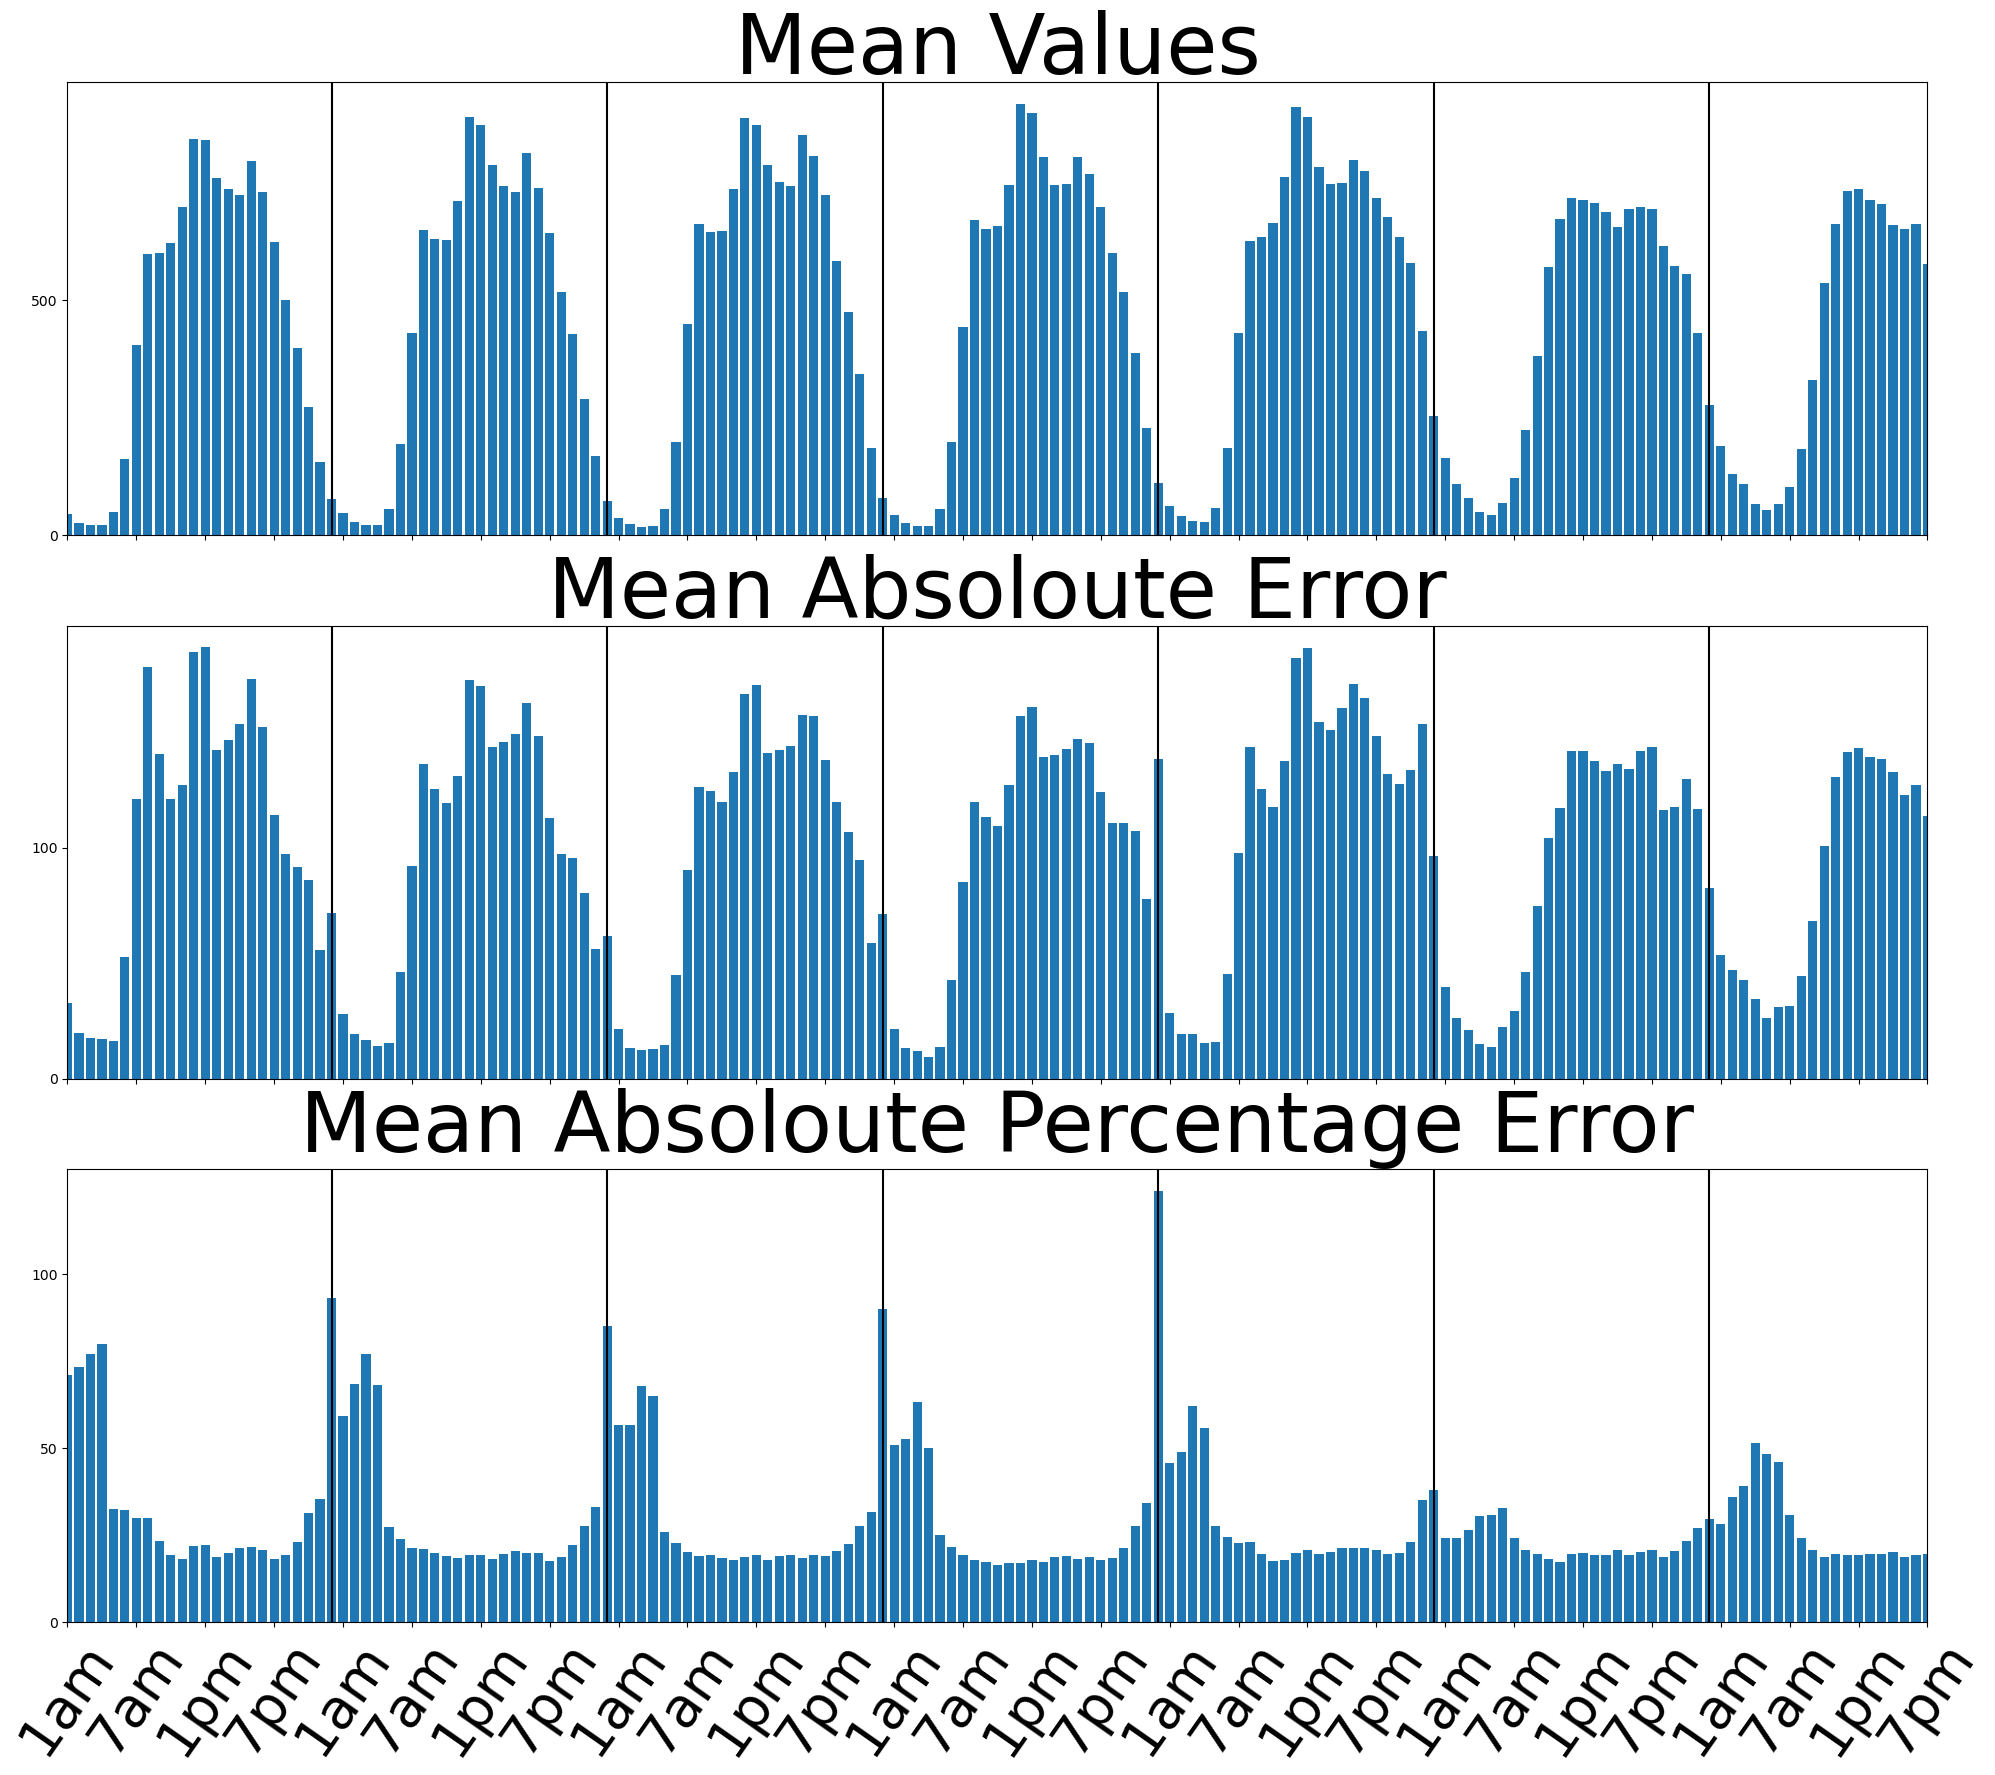

In [32]:
fig,axs =plt.subplots(nrows=3,figsize =(24,20), sharex=True)
axs[0].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_means)#,  yerr=hourofweekly_stds  )
axs[0].set_title('Mean Values', fontsize=60)
axs[1].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_maes)#, yerr=hourofweekly_mae_stds   )
axs[1].set_title('Mean Absoloute Error', fontsize=60)
axs[2].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_mapes )
axs[2].set_title('Mean Absoloute Percentage Error', fontsize=60)
# axs[2].tick_params(axis='x')

# Removes weird whitespace from the start
axs[0].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[1].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[2].set_xlim([1,len(df['hour_of_week'].unique()[::3])])

# Axis labels
axs[2].set_xticks(list(range(1,len(labels)))[::6], fontsize=40)
axs[2].set_xticklabels(labels[::6], fontsize=40, rotation = 55)

params = {'ytick.labelsize': 50}
plt.rcParams.update(params)

for i in range(1,7):
    axs[0].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[1].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[2].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    
fig.savefig('Results/Figs/ModelEvaluation_withCV/Error_by_hour_of_week.jpg')

### Plot errors by hour of day

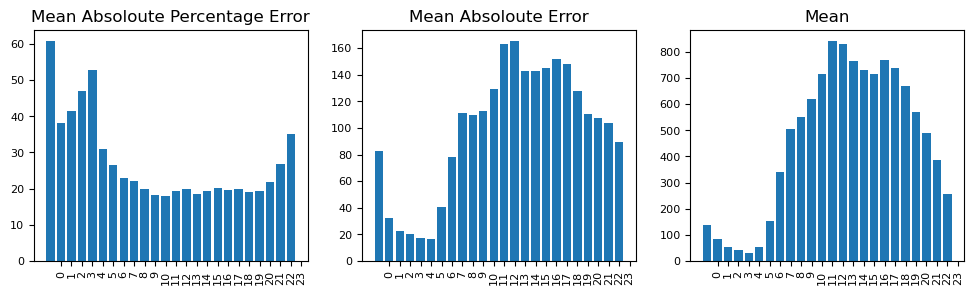

In [33]:
fig,axs =plt.subplots(ncols=3, figsize =(12,3))
axs[0].bar(np.sort(df['Hour'].unique()),hourly_mapes )
axs[0].set_title('Mean Absoloute Percentage Error');
axs[1].bar(np.sort(df['Hour'].unique()),hourly_maes )
axs[1].set_title('Mean Absoloute Error')
axs[2].bar(np.sort(df['Hour'].unique()),hourly_means )
axs[2].set_title('Mean')

axs[0].set_xticks(list(range(1,25)))
axs[0].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[1].set_xticks(list(range(1,25)))
axs[1].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[2].set_xticks(list(range(1,25)))
axs[2].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);

axs[2].tick_params(axis='y', which='major', labelsize=8)
axs[0].tick_params(axis='y', which='major', labelsize=8)
axs[1].tick_params(axis='y', which='major', labelsize=8)

### Plot the errors by sensor

In [34]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

In [35]:
sensorly_errors_df = pd.DataFrame({'sensor_id':np.sort(sensor_ids.unique()),'MAPE':sensorly_mapes,'MAE':sensorly_maes,
                                  'Mean':sensorly_means})
sensorly_errors_df.dropna(inplace=True)
melbourne_sensors = pd.merge(sensorly_errors_df, melbourne_sensors, on='sensor_id', how='left')

### Mean

In [37]:
linear = cm.linear.viridis.scale(melbourne_sensors['Mean'].min(),melbourne_sensors['Mean'].max()).to_step(7)
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.Mean), fill_color = linear(row.Mean),
                      ).add_to(melbourne_map)

# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('Results/Figs/SpatialErrors_mean.png')

melbourne_map

### MAPE

In [38]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAPE'].min(), vmax=melbourne_sensors['MAPE'].max())
linear = cm.linear.viridis.scale(melbourne_sensors['MAPE'].min(),melbourne_sensors['MAPE'].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAPE), fill_color = linear(row.MAPE),
                      ).add_to(melbourne_map)

# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)


img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('Results/Figs/SpatialErrors_MAPE.png')
melbourne_map

### MAE

In [39]:
# linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAE'].min(), vmax=melbourne_sensors['MAE'].max())
linear = cm.linear.viridis.scale(melbourne_sensors['MAE'].min(),melbourne_sensors['MAE'].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAE), fill_color = linear(row.MAE),
                      ).add_to(melbourne_map)


# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('Results/Figs/SpatialErrors_MAE.png')
melbourne_map